In [1]:
# DRAFT experiments for modifying orbital parameters

In [2]:
using SpeedyWeather
using Dates
using GeoMakie
using CairoMakie

In [3]:
# 0. Name
experiment_name = "orbital_half_tilt"

"orbital_half_tilt"

In [4]:
# 1. Define the grid and components
spectral_grid = SpectralGrid(trunc=31, dealiasing=3, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveWetModel, path="/Users/bakera/Dropbox/Postdoc/NCAS/CMSS/SpeedyWeather/output/", id=experiment_name, output_dt=Minute(180))
add!(output, SpeedyWeather.TemperatureOutput(), SpeedyWeather.LargeScalePrecipitationOutput(), SpeedyWeather.ConvectivePrecipitationOutput(), SpeedyWeather.DivergenceOutput())  # additional outputs

NetCDFOutput{Field{Float32, 1, Vector{Float32}, FullGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}
├ status: inactive/uninitialized
├ write restart file: true (if active)
├ interpolator: AnvilInterpolator{Float32, SpeedyWeather.RingGrids.GridGeometry{OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}, Vector{Float32}, Vector{Int64}}, SpeedyWeather.RingGrids.AnvilLocator{Float32, Vector{Float32}, Vector{Int64}}}
├ path: output.nc (overwrite=false)
├ frequency: 10800 seconds
└┐ variables:
 ├ precip_conv: accumulated convective precipitation [mm]
 ├ v: meridional wind [m/s]
 ├ humid: specific humidity [kg/kg]
 ├ temp: temperature [degC]
 ├ div: divergence [s^-1]
 ├ u: zonal wind [m/s]
 ├ pres: surface pressure [hPa]
 ├ precip_cond: accumulated large-scale precipitation [mm]
 └ vor: relative vorticity [s^-1]

In [5]:
# 2. Create land and ocean model components
temperature = LandBucketTemperature(spectral_grid)
soil_moisture = LandBucketMoisture(spectral_grid)
land = LandModel(spectral_grid; temperature, soil_moisture)
ocean = SlabOcean(spectral_grid)

SlabOcean{Float32} <: AbstractOcean
├ temp_equator::Float32 = 302.0
├ temp_poles::Float32 = 273.0
├ specific_heat_capacity::Float32 = 4184.0
├ mixed_layer_depth::Float32 = 10.0
├ density::Float32 = 1000.0
├ mask::Bool = false
└ heat_capacity_mixed_layer::Float32 = 4.184e7

In [6]:
# 3. Make parameterisation choices, set timestepping, apply fixes
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)

time_stepping = Leapfrog(spectral_grid, Δt_at_T31=Minute(40))  # CPL this is the standard time step

albedo = Albedo(GlobalConstantAlbedo(spectral_grid, albedo=0.06), AlbedoClimatology(spectral_grid))  # Try to fix ocean albedo
set!(albedo.land, (λ, φ) -> 0., add=true)

5248-element, 64-ring OctahedralGaussianField{Float32, 1} on Array on SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 ⋮
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0
 0.0f0

In [7]:
# 4. Modify orbital parameter (e.g., halve axial tilt or halve rotation and double length of day)
earth = Earth(spectral_grid,axial_tilt=11.7f0) # unit is degrees
#earth = Earth(spectral_grid,rotation=3.645f-5,length_of_day=127800.0f0) # units are rad/s and s, respectively

Earth{Float32} <: SpeedyWeather.AbstractPlanet
├ rotation::Float32 = 7.29e-5
├ gravity::Float32 = 9.81
├ daily_cycle::Bool = true
├ length_of_day::Second = 86400 seconds
├ seasonal_cycle::Bool = true
├ length_of_year::Second = 31557600 seconds
├ equinox::DateTime = 2000-03-20T00:00:00
├ axial_tilt::Float32 = 11.7
└ solar_constant::Float32 = 1365.0

In [8]:
# 5. Create models and initialise simulations
model_ctl = PrimitiveWetModel(spectral_grid; land, ocean, large_scale_condensation, convection, output=output)
model_exp = PrimitiveWetModel(spectral_grid; land, ocean, large_scale_condensation, convection, planet=earth, output=output)

simulation_ctl = initialize!(model_ctl)
simulation_exp = initialize!(model_exp)

model_exp

[ Info: Time step changed from 2400000 to 2700000 milliseconds (+12%) to match output frequency.
[ Info: Time step changed from 2400000 to 2700000 milliseconds (+12%) to match output frequency.


PrimitiveWetModel <: PrimitiveWet
├ spectral_grid: SpectralGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Spectrum...
├ architecture: SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}
├ dynamics: Bool
├ geometry: Geometry{Float32, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbst...
├ planet: Earth{Float32}
├ atmosphere: EarthAtmosphere{Float32}
├ coriolis: Coriolis{Float32, Vector{Float32}}
├ geopotential: Geopotential{Float32, Vector{Float32}}
├ adiabatic_conversion: AdiabaticConversion{Float32, Vector{Float32}}
├ particle_advection: NoParticleAdvection
├ initial_conditions: InitialConditions{ZonalWind, PressureOnOrography, JablonowskiTemperature,...
├ forcing: NoForcing
├ drag: NoDrag
├ random_process: NoRandomProcess
├ tracers: Dict{Symbol, Tracer}
├ orography: EarthOrography{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{...
├ land_sea_mask: EarthLandSeaMask{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussia...
├ 

In [9]:
# 6. Run the simulation
run!(simulation_ctl, period=Day(365),output=true)
run!(simulation_exp, period=Day(365),output=true)

Weather is speedy: run_orbital_half_tilt_0001 100% Time: 0:03:47 (380.35 years/day)
Weather is speedy: run_orbital_half_tilt_0002 100% Time: 0:03:48 (377.95 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

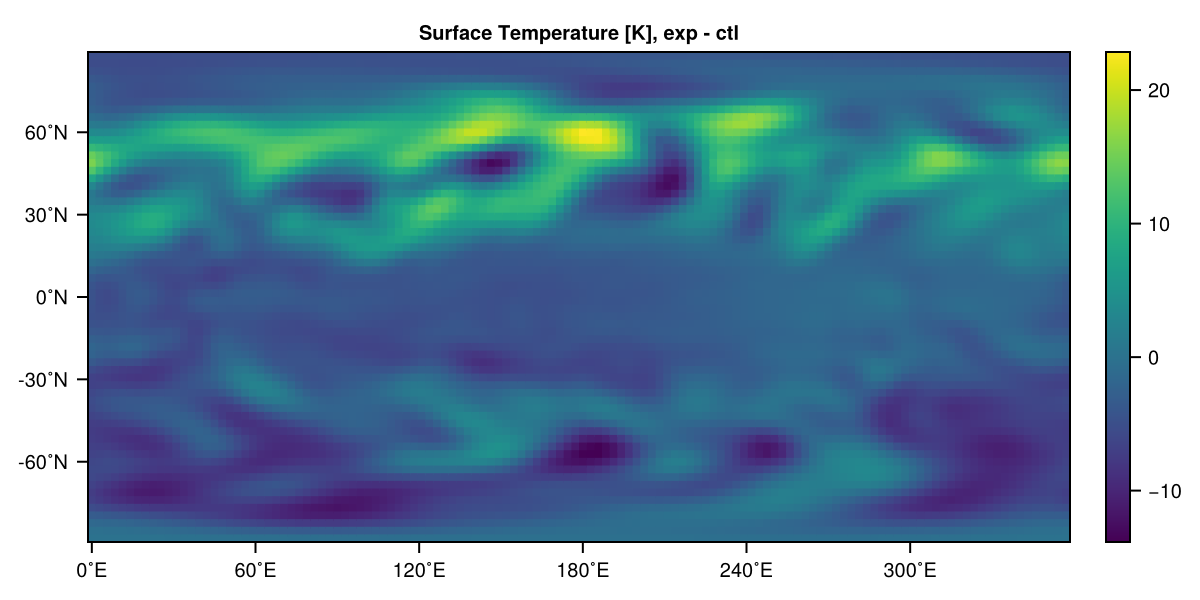

In [10]:
# 7. Simple difference plots
T = simulation_exp.diagnostic_variables.grid.temp_grid[:, end] - simulation_ctl.diagnostic_variables.grid.temp_grid[:, end]
heatmap(T, title="Surface Temperature [K], exp - ctl")

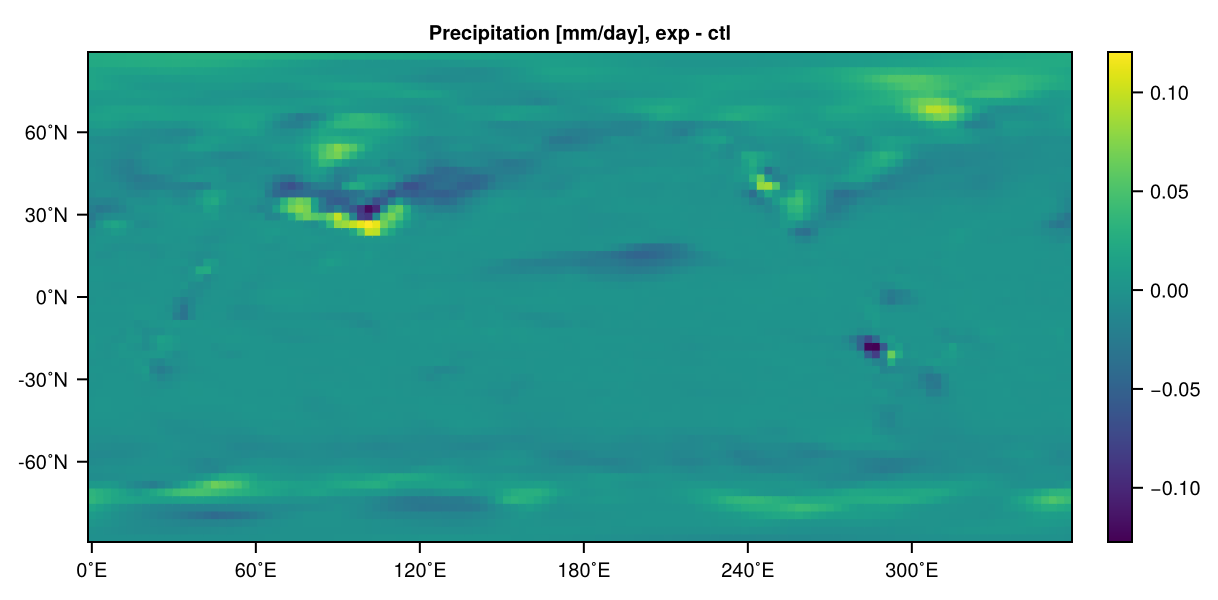

In [11]:
P = simulation_exp.diagnostic_variables.physics.precip_large_scale - simulation_ctl.diagnostic_variables.physics.precip_large_scale
heatmap(P, title="Precipitation [mm/day], exp - ctl")

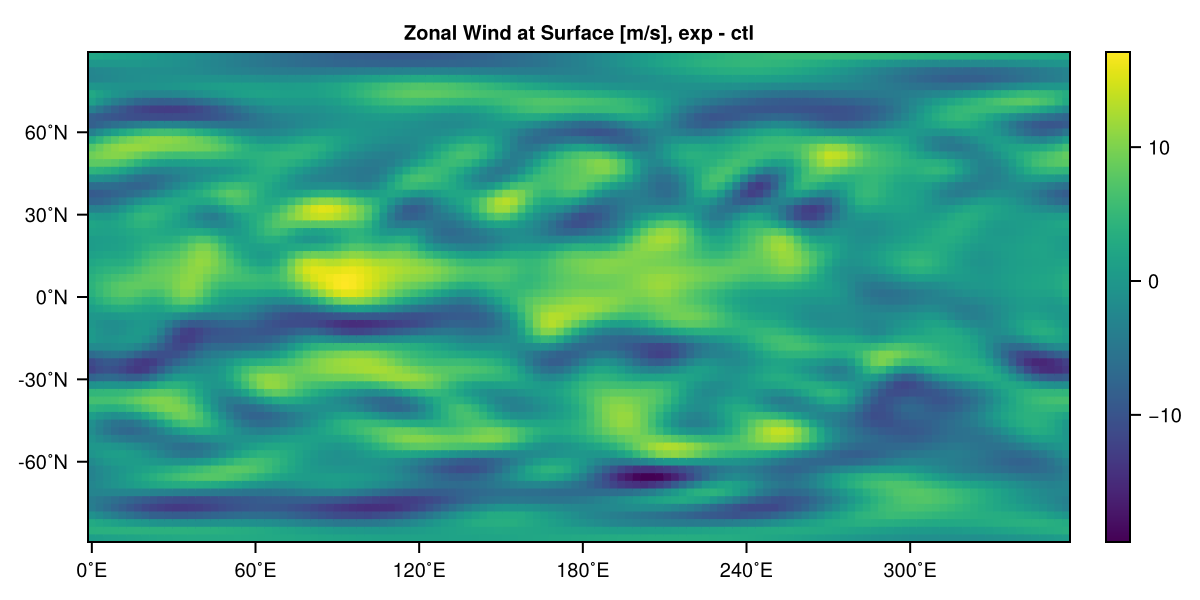

In [12]:
U = simulation_exp.diagnostic_variables.grid.u_grid[:, end] - simulation_ctl.diagnostic_variables.grid.u_grid[:, end]
heatmap(U, title="Zonal Wind at Surface [m/s], exp - ctl")